In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Science/Jax_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#Optimizer
from jax.scipy.optimize import minimize as jax_minimize
from scipy.optimize import minimize as scipy_minimize

#Jaxtronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters



#Jaxified GRF generator
from jaxtronomy.GaussianRandomField.PowerBox_jaxified import get_jaxified_GRF
import jaxtronomy.GaussianRandomField.PowerBox_jaxified as PowerBox_jax

#Utils for GRF fitting
from jaxtronomy.GaussianRandomField.GRF_fitting import get_parameters,get_lens_models,simulate_perturbed_image,simulate_smooth_image,model_loss_function
#Utils for computing axially averaged spectrum
from jaxtronomy.GaussianRandomField.GRF_fitting import Radial_profile,compute_radial_spectrum
#Utils for fitting the GRF
from jaxtronomy.GaussianRandomField.GRF_fitting import GRF_Loss_perfect_case,GRF_Loss_phase_averaging,GRF_Loss_image_fitting,Spectra_Loss_MSE,Spectra_Loss_MAE
#from jaxtronomy.GaussianRandomField.GRF_fitting import fit_image_function,GRF_Loss_complete

#Utils for handling jax
from jaxtronomy.GaussianRandomField.Jax_Utils import purify_function,jax_map,gradient_descent



# Universal font size
FS = 18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Lensing setup (unknown to us)

In [2]:
#GRF true parameters
GRF_LogAmp=-10.
GRF_beta=7.
GRF_seed=1

GRF_params=[GRF_LogAmp,GRF_beta]

## Data grids

In [3]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]

## Models

In [4]:
#Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

#Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)
GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

#Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

## Source light model

In [5]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15,'e1':0.07,'e2':-0.1}]

## Lens model (SIE + external shear)

In [6]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR','PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

GRF_realisation=get_jaxified_GRF([GRF_LogAmp,GRF_beta],GRF_seed,npix,pix_scl)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},\
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0},\
                    {'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': GRF_realisation}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

#Combined kwargs smooth
kwargs_data = {'kwargs_lens': kwargs_lens_mass[:-1], 'kwargs_source': kwargs_source_light,'kwargs_lens_light':kwargs_lens_light}

#Observation conditions and noise
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}

SNR=1000
kwargs_noise={'background_rms': 0.5/SNR, 'exposure_time': np.inf}
noise=Noise(npix, npix, **kwargs_noise)

parameters=get_parameters(kwargs_data,lens_mass_model_list,source_light_model_list)

#Noiseless models
perturbed_lens_image,smooth_lens_image=get_lens_models(pixel_grid,psf,noise,\
                                                       lens_mass_model_list,source_light_model,lens_light_model,kwargs_numerics)

## Simulate data image

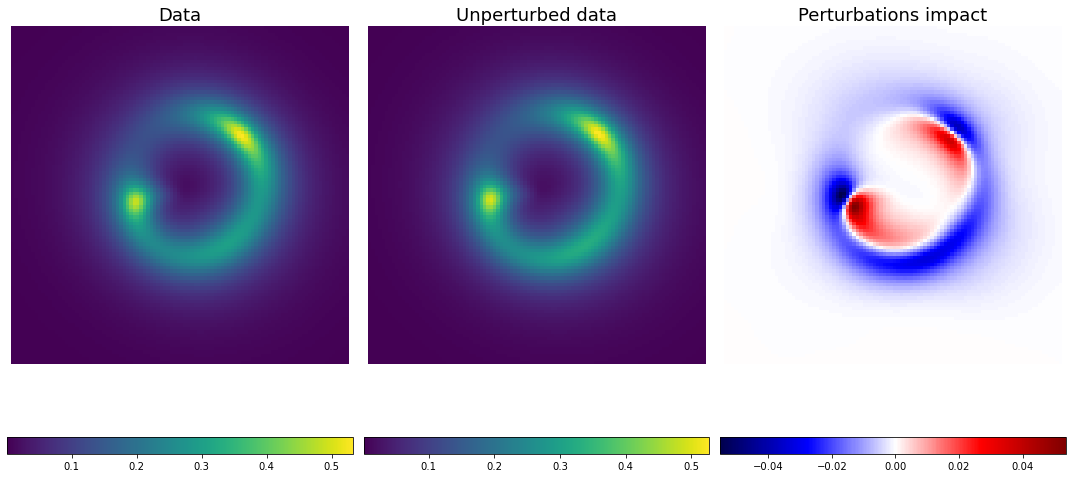

In [7]:
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)
data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)


# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

im0=ax[0].imshow(data_image, origin='lower')
ax[0].set_title("Data", fontsize=FS)


im1=ax[1].imshow(simulate_smooth_image(kwargs_data,smooth_lens_image), origin='lower')
ax[1].set_title("Unperturbed data", fontsize=FS)

im2=ax[2].imshow(data_image-simulate_smooth_image(kwargs_data,smooth_lens_image), origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
ax[2].set_title("Perturbations impact", fontsize=FS)

for i,img in enumerate([im0,im1, im2]):
    ax[i].axis('off')
    fig.colorbar(img, ax=ax[i],orientation='horizontal')

fig.tight_layout()

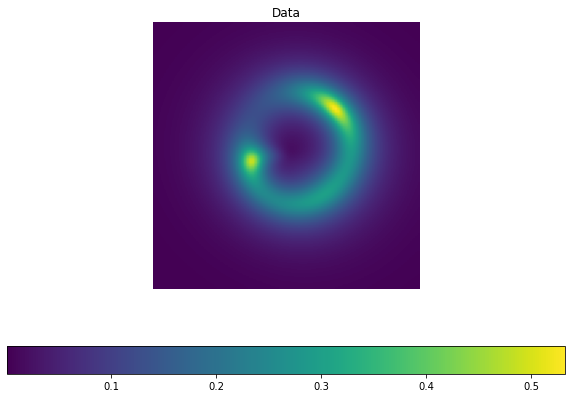

In [8]:
#needed to compute noise realisation
smooth_lens_image.simulation(compute_true_noise_map=True,**kwargs_data)

data_image=simulate_perturbed_image(GRF_realisation,kwargs_data,perturbed_lens_image,x_coords,y_coords)

plt.figure(figsize=(10,7))
im=plt.imshow(data_image, origin='lower')
plt.title('Data')
plt.axis('off')
plt.colorbar(im,orientation='horizontal')

# Data preparation

## Fit data to know lens-source kwargs

In [9]:
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer


def fit_data(data,lens_image,parameters,method='BFGS'):

  loss = Loss(data, lens_image, parameters)
  grad_loss = jax.jit(jax.grad(loss))

  optimizer = Optimizer(loss, parameters)
  #BFGS for gradient only, Newton-CG for graident+ hessian vector product
  #BFGS is faster since it doesn't compute hessian vp
  best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method=method, restart_from_init=True,
                         use_exact_hessian_if_allowed=False)
    
  kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

  return kwargs_final

In [10]:
#First guess from priors
kwargs_intermediate={'kwargs_lens': [{'theta_E': 1.5,'e1': 1e-3,'e2': 1e-3,'center_x': 1e-3,'center_y': 1e-3},{'gamma1': 1e-3, 'gamma2': 1e-3, 'ra_0': 0.0, 'dec_0': 0.0}],
                     'kwargs_source': [{'amp': 5.0,'R_sersic': 2.5,'n_sersic': 2.,'center_x': 0.,'center_y': 0.,'e1': 1e-3,'e2': 1e-3}],
                     'kwargs_lens_light': [{}]}

parameters=get_parameters(kwargs_intermediate,lens_mass_model_list,source_light_model_list)
#Get guess of true kwargs
kwargs_guess=fit_data(data_image,smooth_lens_image,parameters,method='Newton-CG')
args_guess=parameters.kwargs2args(kwargs_guess)

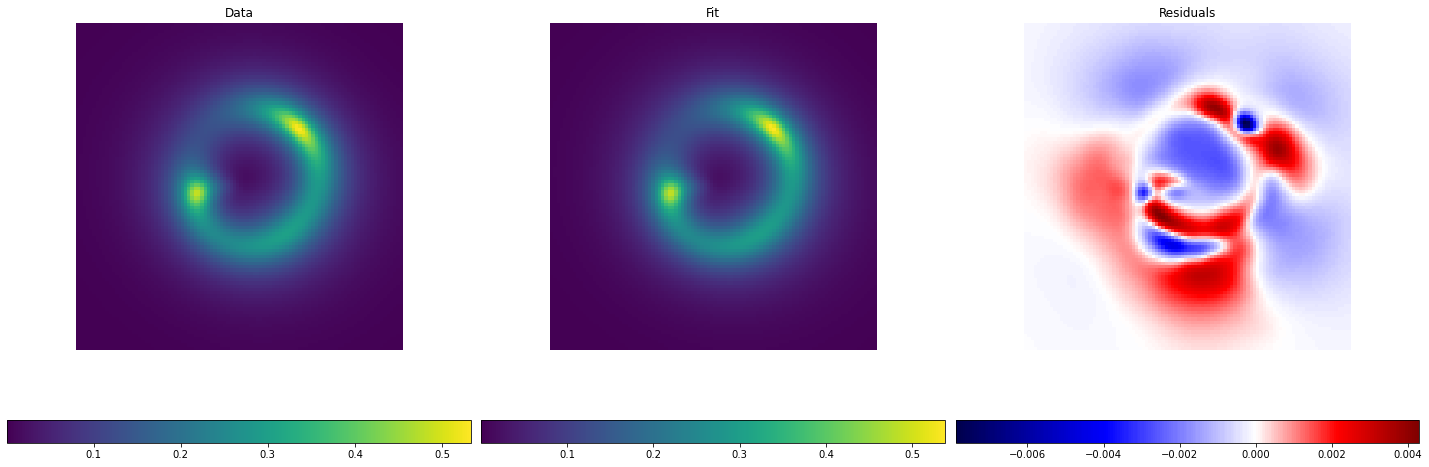

In [11]:
parameter_names=deepcopy(parameters.symbols)

parameter_names[1:5]=['$e_1^{lens}$','$e_2^{lens}$','$x_{0}^{lens}$', '$y_{0}^{lens}$']
parameter_names[-4:]=['$e_1^{source}$','$e_2^{source}$','$x_{0}^{source}$', '$y_{0}^{source}$']

fig,ax=plt.subplots(1,3,figsize=(20,7))

im_arr=[]

im=ax[0].imshow(data_image,origin='lower')
im_arr+=[im]
ax[0].set_title('Data')

fit_image=smooth_lens_image.model(**kwargs_guess)
im=ax[1].imshow(fit_image,origin='lower')
im_arr+=[im]
ax[1].set_title('Fit')

im=ax[2].imshow(data_image-fit_image,origin='lower',cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
im_arr+=[im]
ax[2].set_title('Residuals')

for i in range(3):
    ax[i].axis('off')
    fig.colorbar(im_arr[i],ax=ax[i],orientation='horizontal')
    
fig.tight_layout()
plt.show()

## Einstein ring Mask

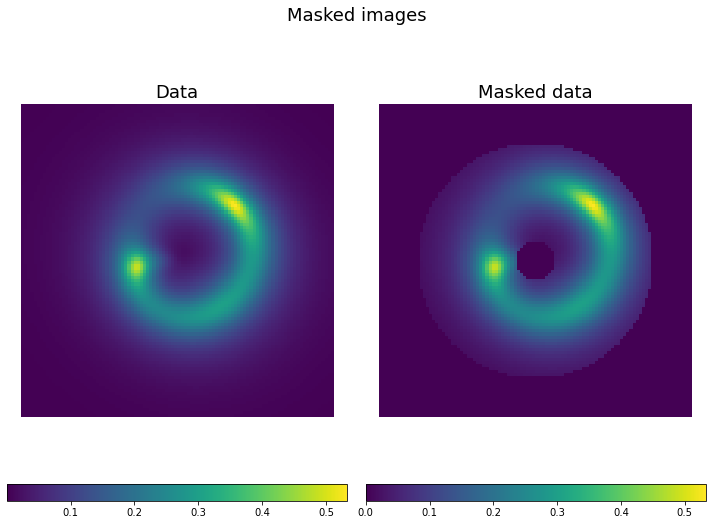

In [12]:
rmin = 0.5
rmax = 3
radius = np.hypot(xgrid, ygrid)
#Mask covering Einstein ring
mask = ((radius >= rmin) & (radius <= rmax)).astype(bool)

#There is no sense to consider Fourier space frequncies referring to sizes 
#That are bigger than the thickness of the masked region
k_vector=np.fft.fftshift(np.fft.fftfreq(npix,pix_scl))[npix//2:]
#Index from which to consider frequencies
mask_spectral_cut_index=np.where(k_vector>1/(rmax-rmin))[0][0]
masked_k_vector=k_vector[mask_spectral_cut_index:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
img1 = ax1.imshow(data_image, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(data_image*mask, origin='lower')
ax2.set_title("Masked data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax,orientation='horizontal')
    ax.axis('off')
fig.suptitle('Masked images',y=1.1,fontsize=FS)
fig.tight_layout()

## Precompile utility functions

In [13]:
# Precompile the functions with all the arguments that are static for the lensing setup
# So the pure functions depend only on the argument that should be traced

#Generate GRF
def get_jaxified_GRF_pure(GRF_params,GRF_seed):
  return get_jaxified_GRF(GRF_params,GRF_seed,npix,pix_scl)

#Simulate images for kwargs or GRF
simulate_perturbed_image_pure=purify_function(simulate_perturbed_image,kwargs_guess,perturbed_lens_image,x_coords,y_coords)
simulate_smooth_image_pure=purify_function(simulate_smooth_image,smooth_lens_image)

#Get axially averaged spectrum
Radial_profile_pure=purify_function(Radial_profile,(npix,npix))
compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Radial_profile,mask,mask_spectral_cut_index)

## Make the fit

In [14]:
learning_rate=5e-4
max_iter=200

model_loss_function_pure=purify_function(model_loss_function,data_image,parameters,simulate_smooth_image_pure)
model_loss_grad=jax.grad(model_loss_function_pure)

args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
fit_image=smooth_lens_image.model(**parameters.args2kwargs(args_fit))

In [15]:
#They are the same for the same GRF phase
#On the fitting stage of GRF they will be different
args_fit-args_guess

DeviceArray([-4.81180742e-05, -1.26813694e-04,  5.82724354e-05,
              1.78916446e-05, -5.81883126e-06, -8.12293123e-05,
              3.70508861e-05,  7.55539761e-04,  2.08315220e-04,
             -5.74038651e-05,  1.36074701e-04, -1.11985470e-04,
              4.55133131e-05, -4.12393003e-05], dtype=float64)

## Extract spectrum

In [16]:
#Compute Target Power spectrum of data residuals 
data_resid=data_image-fit_image
data_resid_spectrum=compute_radial_spectrum_pure(data_resid)

## Fit spectrum with powerlaw to get Guess of GRF's Power slope

In [17]:
#First assumption is that power spectrum of GRF is close to power spectrum of residuals
#So fit the target power spectrum with a powerlaw to get an initial guess

def Powerlaw_spectrum(params,masked_k_vector):
  logA,Beta=params
  return np.power(10,logA)*np.power(masked_k_vector,-Beta)

def GRF_PS_loss(params,masked_k_vector,Target_spectrum):
  logA,Beta=params
  GRF_spectrum=Powerlaw_spectrum(params,masked_k_vector)
  MSE= np.power((Target_spectrum-GRF_spectrum)/Target_spectrum,2)
  return np.mean(MSE)

#Make a fit
res=scipy_minimize(GRF_PS_loss,x0=[0.,5.],args=(masked_k_vector,data_resid_spectrum))
GRF_init_guess=np.array(res.x)

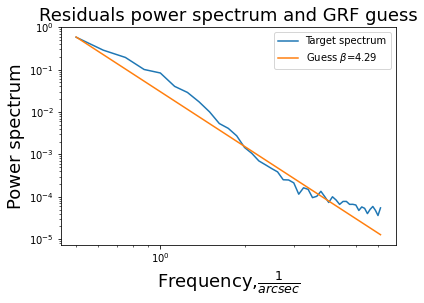

In [18]:
#Plot power spectrum and initial guess
plt.loglog(masked_k_vector,data_resid_spectrum,label='Target spectrum')
plt.loglog(masked_k_vector,Powerlaw_spectrum(GRF_init_guess,masked_k_vector),label='Guess '+r'$\beta$'+'={:.2f}'.format(GRF_init_guess[1]))
plt.xlabel('Frequency,' r'$\frac{1}{arcsec}$',fontsize=FS)
plt.ylabel('Power spectrum',fontsize=FS)
plt.title('Residuals power spectrum and GRF guess',fontsize=FS)
plt.legend()
plt.show()

# GRF fitting 1 (guess the vicinity)

In [19]:
#We work with MAE and only 1 seed realisation to approach the vicinity of the true GRF parameters

Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,data_resid_spectrum)

GRF_seed_guess=2
#The guessed seed should be different from the true one
assert GRF_seed!=GRF_seed_guess

GRF_Loss_image_fitting_args=(GRF_seed_guess,
                            get_jaxified_GRF_pure,simulate_perturbed_image_pure,\
                            simulate_smooth_image_pure,model_loss_function,parameters,\
                            args_guess,learning_rate,max_iter,\
                            compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_image_fitting,*GRF_Loss_image_fitting_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [53]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)

372 ms ± 29.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.7 s ± 493 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There are no chances to use hessian in GRF fitting if we fit the lens kwargs inside the loss function.   
Since kwargs fitting is a recursive loop with 100 cycles propagating grads through it becomes very challenging

## Optimization 1

In [21]:
Nfeval = 0
history=np.zeros((0,2))
init_guess=(-15.,GRF_init_guess[1])
bounds=((-15., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    if (len(history)%10==0):
        print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

   0   -15.000000    4.285290    1.000000   -0.000001 -0.000000
  10   -12.984191    5.046603    0.999941   -0.000136 -0.000028
  20   -12.500999    4.506063    0.999847   -0.000353 -0.000021
  30   -12.496294    4.506520    0.999845   -0.000357 -0.000021
  40   -12.491544    4.506981    0.999843   -0.000361 -0.000022
  50   -12.486749    4.507444    0.999842   -0.000365 -0.000022
  60   -12.481908    4.507911    0.999840   -0.000369 -0.000022
  70   -12.477020    4.508381    0.999838   -0.000373 -0.000022
  80   -12.472084    4.508854    0.999836   -0.000377 -0.000023
  90   -12.467099    4.509331    0.999834   -0.000382 -0.000023
 100   -12.462064    4.509811    0.999832   -0.000386 -0.000023
 110   -12.456977    4.510295    0.999830   -0.000391 -0.000024
 120   -12.451838    4.510782    0.999828   -0.000395 -0.000024
 130   -12.446645    4.511273    0.999826   -0.000400 -0.000024
 140   -12.441397    4.511768    0.999824   -0.000405 -0.000025
 150   -12.436093    4.512266    0.99982

In [22]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

100%|███████████████████████████████████████| 1000/1000 [24:31<00:00,  1.47s/it]


In [23]:
np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_1/history.npy',history)
np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_1/loss_history.npy',loss_history)
np.save(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_1/grads_history.npy',grads_history)

In [ ]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_1/history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_1/loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_1/grads_history.npy',allow_pickle=True)
GRF_guess_1=history[-1]

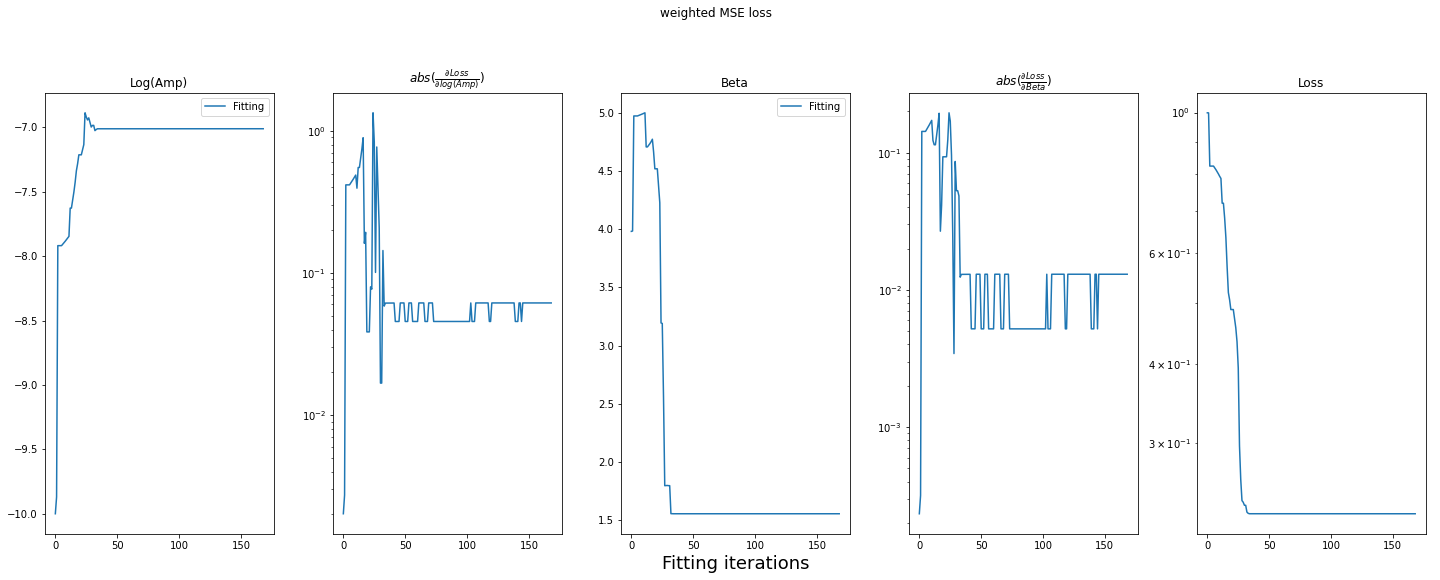

In [57]:
fig,ax=plt.subplots(1,5,figsize=(20,7))

ax[0].plot(history[:,0],label='Fitting')
ax[0].set_title('Log(Amp)')
#We don't know the true value
#ax[0].hlines(GRF_LogAmp,0,len(history),color='red',label='G.T.')
#ax[0].hlines(bounds[0][0],0,len(history),color='black',label='Bounds')
#ax[0].hlines(bounds[0][1],0,len(history),color='black',label='Bounds')
ax[0].legend()



grads_history=np.array(grads_history)
loss_history=np.array(loss_history)

ax[1].plot(np.abs(grads_history[:,0]))
ax[1].set_yscale('log')
ax[1].set_title(r'$abs(\frac{\partial Loss}{\partial log(Amp)})$')


ax[2].plot(history[:,1],label='Fitting')
ax[2].set_title('Beta')
#We don't know the true value
#ax[2].hlines(GRF_beta,0,len(history),color='red',label='G.T.')
ax[2].legend()

ax[3].plot(np.abs(grads_history[:,1]))
ax[3].set_title(r'$abs(\frac{\partial Loss}{\partial Beta})$')
ax[3].set_yscale('log')



ax[4].plot(loss_history)
ax[4].set_yscale('log')
ax[4].set_title('Loss')

fig.tight_layout()
fig.suptitle('weighted MSE loss',y=1.1)



fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fitting iterations',fontsize=FS)

plt.show()

# GRF fitting 2 MAE (fine-tune the guess)

## Complete fitting setup

In [24]:
def fit_image_function(simulated_image,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate):
    model_loss_function_pure=purify_function(model_loss_function,simulated_image,parameters,simulate_smooth_image_pure)
    model_loss_grad=jax.grad(model_loss_function_pure)

    args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
    fit_image=simulate_smooth_image_pure(parameters.args2kwargs(args_fit))
    return fit_image

fit_image_function_pure=purify_function(fit_image_function,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate)

In [25]:
def GRF_Loss_complete(GRF_params,GRF_seeds,get_jaxified_GRF_pure,\
                      simulate_perturbed_image_pure,fit_image_function_pure,\
                      compute_radial_spectrum_pure,Spectra_Loss_pure):

  #Mapping GRF generator over seeds
  get_GRF=lambda GRF_seed: get_jaxified_GRF_pure(GRF_params,GRF_seed)
  GRFs=jax_map(get_GRF,GRF_seeds)

  #Mapping image generator over seeds
  simulated_images=jax_map(simulate_perturbed_image_pure,GRFs)
  #Fitting obtained simulations
  fitted_images=jax_map(fit_image_function_pure,simulated_images)

  #Getting the residuals
  resids=simulated_images-fitted_images

  #Map over residuals for each seed
  resid_spectra=jax_map(compute_radial_spectrum_pure,resids)

  Spectra_Losses=jax_map(Spectra_Loss_pure,resid_spectra)

  return jnp.mean(Spectra_Losses)

In [26]:
#We work with MAE and only 1 seed realisation to approach the vicinity of the true GRF parameters

Spectra_Loss_pure=purify_function(Spectra_Loss_MAE,data_resid_spectrum)

Seeds_number=5
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)

GRF_Loss_complete_args=(GRF_seeds,get_jaxified_GRF_pure,
                             simulate_perturbed_image_pure,fit_image_function_pure,\
                             compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_complete,*GRF_Loss_complete_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [65]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)

1.52 s ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.2 s ± 1.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
#Well, everything seems to be quite bad in terms of optimization speed

## Optimization 2

In [27]:
Nfeval = 0
history=np.zeros((0,2))
#The values obtained on the previous stage
init_guess=GRF_guess_1
bounds=((-15., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    #if (len(history)%10==0):
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

NameError: name 'GRF_guess_1' is not defined

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [ ]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_2/history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_2/loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_2/grads_history.npy',allow_pickle=True)
GRF_fit=history[-1]

# GRF fitting 2 MSE (fine-tune the guess)

## Complete fitting setup

In [ ]:
def fit_image_function(simulated_image,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate):
    model_loss_function_pure=purify_function(model_loss_function,simulated_image,parameters,simulate_smooth_image_pure)
    model_loss_grad=jax.grad(model_loss_function_pure)

    args_fit=gradient_descent(model_loss_grad,args_guess,max_iter,learning_rate)
    fit_image=simulate_smooth_image_pure(parameters.args2kwargs(args_fit))
    return fit_image

fit_image_function_pure=purify_function(fit_image_function,parameters,simulate_smooth_image_pure,args_guess,max_iter,learning_rate)

In [ ]:
def GRF_Loss_complete(GRF_params,GRF_seeds,get_jaxified_GRF_pure,\
                      simulate_perturbed_image_pure,fit_image_function_pure,\
                      compute_radial_spectrum_pure,Spectra_Loss_pure):

  #Mapping GRF generator over seeds
  get_GRF=lambda GRF_seed: get_jaxified_GRF_pure(GRF_params,GRF_seed)
  GRFs=jax_map(get_GRF,GRF_seeds)

  #Mapping image generator over seeds
  simulated_images=jax_map(simulate_perturbed_image_pure,GRFs)
  #Fitting obtained simulations
  fitted_images=jax_map(fit_image_function_pure,simulated_images)

  #Getting the residuals
  resids=simulated_images-fitted_images

  #Map over residuals for each seed
  resid_spectra=jax_map(compute_radial_spectrum_pure,resids)

  Spectra_Losses=jax_map(Spectra_Loss_pure,resid_spectra)

  return jnp.mean(Spectra_Losses)

In [ ]:
#We work with MAE and only 1 seed realisation to approach the vicinity of the true GRF parameters

Spectra_Loss_pure=purify_function(Spectra_Loss_MSE,data_resid_spectrum)

Seeds_number=5
GRF_seeds=np.arange(GRF_seed+1,GRF_seed+1+Seeds_number)

GRF_Loss_complete_args=(GRF_seeds,get_jaxified_GRF_pure,
                             simulate_perturbed_image_pure,fit_image_function_pure,\
                             compute_radial_spectrum_pure,Spectra_Loss_pure)

GRF_Loss_pure=purify_function(GRF_Loss_complete,*GRF_Loss_complete_args)
loss_func=GRF_Loss_pure
grad_loss_func=jax.grad(GRF_Loss_pure)
hess_loss_func=jax.jacfwd(jax.jacrev(loss_func))

In [65]:
%timeit loss_func(GRF_params)
%timeit grad_loss_func(GRF_params)

1.52 s ± 5.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.2 s ± 1.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
#Well, everything seems to be quite bad in terms of optimization speed

## Optimization 2

In [ ]:
Nfeval = 0
history=np.zeros((0,2))
#The values obtained on the previous stage
init_guess=GRF_guess_1
bounds=((-15., -0.), (1., 10.0))

def callbackF(Xi,optimizer):
    global Nfeval
    global history
    
    loss=loss_func(Xi)
    grad=grad_loss_func(Xi)
    #if (len(history)%10==0):
    print('{0:4d}   {1:3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f} {5: 3.6f}'.format(Nfeval, Xi[0], Xi[1], loss,grad[0],grad[1]))
    
    Nfeval += 1
    history=np.append(history,[Xi],axis=0)

#Don't use hessian due to tis high computational cost
res=scipy_minimize(loss_func,init_guess,jac=grad_loss_func,bounds=bounds,method='trust-constr',options={'disp': True},callback=callbackF)

In [ ]:
loss_history=np.array([loss_func(x) for x in tqdm(history)])
grads_history=np.array([grad_loss_func(x) for x in tqdm(history)])

In [ ]:
history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_2/MSE_history.npy',allow_pickle=True)
loss_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_2/MSE_loss_history.npy',allow_pickle=True)
grads_history=np.load(Folder+'Data/Algorithm_test/LogAmp=-10_Beta=7/Fitting_2/MSE_grads_history.npy',allow_pickle=True)
GRF_fit=history[-1]